In [1]:
"""Importing Libraries"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plotly for interactive charts
import plotly.express as px
import plotly.graph_objs as go

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
try:
    import gdown
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "--upgrade", "gdown"])
    import gdown

file_id = "16roDpQxTS2s-X7Lxg8wwEaoZ89k16I6V"
output_path = os.path.join("data", "all_stocks_5yr.csv")
os.makedirs("data", exist_ok=True)

if not os.path.exists(output_path):
    print("⬇️ Downloading dataset...")
    gdown.download(id=file_id, output=output_path, quiet=False)
else:
    print("✅ Dataset already exists.")

⬇️ Downloading dataset...


Downloading...
From: https://drive.google.com/uc?id=16roDpQxTS2s-X7Lxg8wwEaoZ89k16I6V
To: /content/data/all_stocks_5yr.csv
100%|██████████| 29.6M/29.6M [00:00<00:00, 92.3MB/s]


In [4]:
"""Data Cleaning process"""

data = pd.read_csv(output_path)
data['date'] = pd.to_datetime(data['date'])
data.sort_values(['Name', 'date'], inplace=True)
data.reset_index(drop=True, inplace=True)

print(data.shape)
print(data.columns)
print(data['Name'].nunique())  # Number of unique stocks
data.isnull().sum()

df = pd.DataFrame(data)

print("Original DataFrame:")
print(df)


(619040, 7)
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')
505
Original DataFrame:
             date   open   high    low  close   volume Name
0      2013-02-08  45.07  45.35  45.00  45.08  1824755    A
1      2013-02-11  45.17  45.18  44.45  44.60  2915405    A
2      2013-02-12  44.81  44.95  44.50  44.62  2373731    A
3      2013-02-13  44.81  45.24  44.68  44.75  2052338    A
4      2013-02-14  44.72  44.78  44.36  44.58  3826245    A
...           ...    ...    ...    ...    ...      ...  ...
619035 2018-02-01  76.84  78.27  76.69  77.82  2982259  ZTS
619036 2018-02-02  77.53  78.12  76.73  76.78  2595187  ZTS
619037 2018-02-05  76.64  76.92  73.18  73.83  2962031  ZTS
619038 2018-02-06  72.74  74.56  72.13  73.27  4924323  ZTS
619039 2018-02-07  72.70  75.00  72.69  73.86  4534912  ZTS

[619040 rows x 7 columns]


In [5]:
# Fill missing values with the mean of specific columns: 'open', 'high', and 'low'
columns_to_fill = ['open', 'high', 'low']
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].mean())

print("\nDataFrame after filling missing values with the average in specified columns:")
print(df)

df.isnull().sum()


DataFrame after filling missing values with the average in specified columns:
             date   open   high    low  close   volume Name
0      2013-02-08  45.07  45.35  45.00  45.08  1824755    A
1      2013-02-11  45.17  45.18  44.45  44.60  2915405    A
2      2013-02-12  44.81  44.95  44.50  44.62  2373731    A
3      2013-02-13  44.81  45.24  44.68  44.75  2052338    A
4      2013-02-14  44.72  44.78  44.36  44.58  3826245    A
...           ...    ...    ...    ...    ...      ...  ...
619035 2018-02-01  76.84  78.27  76.69  77.82  2982259  ZTS
619036 2018-02-02  77.53  78.12  76.73  76.78  2595187  ZTS
619037 2018-02-05  76.64  76.92  73.18  73.83  2962031  ZTS
619038 2018-02-06  72.74  74.56  72.13  73.27  4924323  ZTS
619039 2018-02-07  72.70  75.00  72.69  73.86  4534912  ZTS

[619040 rows x 7 columns]


,0
date,0
open,0
high,0
low,0
close,0
volume,0
Name,0


In [7]:
# Moving Averages
df['MA_7'] = df['close'].rolling(window=7).mean()
df['MA_30'] = df['close'].rolling(window=30).mean()

# Volatility (Standard Deviation)
df['Volatility'] = df['close'].rolling(window=7).std()

# Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['close'])

In [8]:
# Drop NaN values from feature engineering
df.dropna(inplace=True)

df.head()

# Normalize Data

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['close', 'MA_7', 'MA_30', 'Volatility', 'RSI']])

In [9]:
# formation of Time-Series Sequences

def create_sequences(data, time_steps=50):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])  # Predicting 'close' price
    return np.array(X), np.array(y)

time_steps = 50
X, y = create_sequences(df_scaled, time_steps)

In [10]:
# Train-Test Split
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, {y_test.shape}")

Training Data Shape: (495168, 50, 5), (495168,)
Testing Data Shape: (123793, 50, 5), (123793,)


In [11]:
# Build & Train LSTM model

# Define LSTM Model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 133s 8ms/step - loss: 1.6054e-04 - val_loss: 4.9721e-06
Epoch 2/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 134s 9ms/step - loss: 5.0609e-05 - val_loss: 5.8821e-06
Epoch 3/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 134s 8ms/step - loss: 4.8782e-05 - val_loss: 3.7202e-06
Epoch 4/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 151s 9ms/step - loss: 3.8574e-05 - val_loss: 1.9295e-06
Epoch 5/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 141s 9ms/step - loss: 3.8353e-05 - val_loss: 3.4652e-06
Epoch 6/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 142s 9ms/step - loss: 3.4118e-05 - val_loss: 2.6140e-06
Epoch 7/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 143s 9ms/step - loss: 3.4506e-05 - val_loss: 4.5587e-06
Epoch 8/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 142s 9ms/step - loss: 3.0219e-05 - val_loss: 2.0455e-06
Epoch 9/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 141s 9ms/step - loss: 3.6144e-05 - val_loss: 4.0209e-06
Epoch 10/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 140s 9ms/step - loss: 3.2081e-05 - val_loss: 2.6514e-06

In [14]:
# Define GRU Model
model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout

Epoch 1/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 135s 9ms/step - loss: 1.3466e-04 - val_loss: 1.1897e-05
Epoch 2/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 132s 9ms/step - loss: 4.9631e-05 - val_loss: 6.2340e-06
Epoch 3/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 136s 8ms/step - loss: 3.9814e-05 - val_loss: 1.0171e-05
Epoch 4/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 134s 9ms/step - loss: 4.1018e-05 - val_loss: 3.9158e-06
Epoch 5/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 135s 8ms/step - loss: 3.5022e-05 - val_loss: 3.7605e-06
Epoch 6/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 141s 8ms/step - loss: 3.6037e-05 - val_loss: 2.4677e-06
Epoch 7/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 149s 9ms/step - loss: 3.9880e-05 - val_loss: 5.6144e-06
Epoch 8/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 142s 9ms/step - loss: 3.7962e-05 - val_loss: 2.5807e-06
Epoch 9/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 134s 8ms/step - loss: 3.0228e-05 - val_loss: 2.9296e-06
Epoch 10/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 133s 9ms/step - loss: 3.2783e-05 - val_loss: 1.4442e-05

In [15]:
# Define CNN model
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile CNN model
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train CNN model
history_cnn = model_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 6.6064e-04 - val_loss: 1.6655e-05
Epoch 2/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 1.9043e-04 - val_loss: 9.0602e-06
Epoch 3/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - loss: 1.5211e-04 - val_loss: 7.1034e-06
Epoch 4/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 1.4586e-04 - val_loss: 1.2364e-05
Epoch 5/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 1.5216e-04 - val_loss: 7.4740e-06
Epoch 6/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.5178e-04 - val_loss: 1.6429e-05
Epoch 7/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 1.5392e-04 - val_loss: 1.3431e-05
Epoch 8/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 1.4933e-04 - val_loss: 8.4399e-06
Epoch 9/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - loss: 1.4974e-04 - val_loss: 1.3621e-05
Epoch 10/20
15474/15474 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.5598e-04 - val_loss: 6.4084e-06
Epoch 11/

In [16]:
# STEP 1: Predictions
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)
y_pred_cnn = model_cnn.predict(X_test)


3869/3869 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
3869/3869 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
3869/3869 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [17]:
# STEP 2: Inverse transform predictions and actual
pad_width = df_scaled.shape[1] - 1  # Number of additional features
# Pad zeros for inverse transform
y_pred_lstm_full = scaler.inverse_transform(np.hstack((y_pred_lstm, np.zeros((len(y_pred_lstm), pad_width)))))
y_pred_gru_full = scaler.inverse_transform(np.hstack((y_pred_gru, np.zeros((len(y_pred_gru), pad_width)))))
y_pred_cnn_full = scaler.inverse_transform(np.hstack((y_pred_cnn, np.zeros((len(y_pred_cnn), pad_width)))))
y_test_full = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), pad_width)))))

In [18]:
# Extract actual and predicted closing prices
y_pred_lstm = y_pred_lstm_full[:, 0]
y_pred_gru = y_pred_gru_full[:, 0]
y_pred_cnn = y_pred_cnn_full[:, 0]
y_test_inv = y_test_full[:, 0]

In [19]:
# Pad y_test with dummy zeros to match the original number of features (5)
y_test_padded = np.hstack((y_test.reshape(-1, 1), np.zeros((len(y_test), df_scaled.shape[1] - 1))))
y_test_actual = scaler.inverse_transform(y_test_padded)[:, 0]  # Extract only the 'close' column

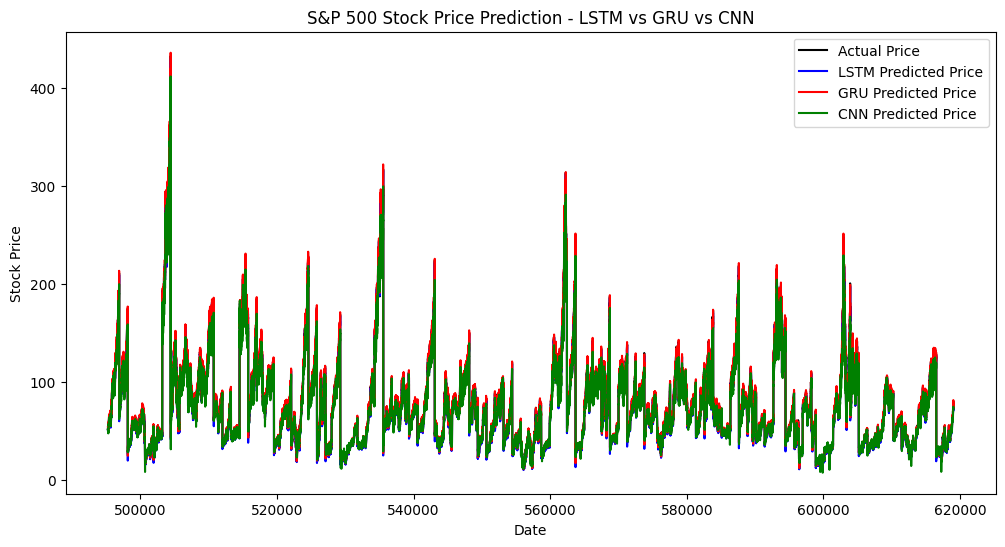

In [20]:
# Plot the predictions against actual prices
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual Price', color='black')
plt.plot(df.index[-len(y_test):], y_pred_lstm, label='LSTM Predicted Price', color='blue')
plt.plot(df.index[-len(y_test):], y_pred_gru, label='GRU Predicted Price', color='red')
plt.plot(df.index[-len(y_test):], y_pred_cnn, label='CNN Predicted Price', color='green')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('S&P 500 Stock Price Prediction - LSTM vs GRU vs CNN')
plt.legend()
plt.show()

In [21]:
# Create DataFrame for summary
results_df = pd.DataFrame({
    'Date': df.index[-len(y_test):],
    'Actual Price': y_test_actual,
    'LSTM Predicted': y_pred_lstm,
    'GRU Predicted': y_pred_gru,
    'CNN Predicted': y_pred_cnn
})

In [22]:
# Show top 10 rows
results_df.head(10)

,Date,Actual Price,LSTM Predicted,GRU Predicted,CNN Predicted
0,495247,51.69,51.203488,53.737338,51.687548
1,495248,51.90,50.634304,53.275069,51.312343
2,495249,51.26,50.698766,53.372353,50.927444
3,495250,51.21,50.122104,52.791565,50.454791
4,495251,50.98,50.416594,52.974664,50.629003
5,495252,50.77,50.004149,52.546713,50.418531
6,495253,50.85,50.107887,52.392343,50.262375
7,495254,51.11,50.256167,52.539548,50.064671
8,495255,50.86,50.714493,52.720785,50.370384
9,495256,51.02,50.284723,52.297167,49.728784


from matplotlib import pyplot as plt
_df_0['Date'].plot(kind='hist', bins=20, title='Date')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Actual Price'].plot(kind='hist', bins=20, title='Actual Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['LSTM Predicted'].plot(kind='hist', bins=20, title='LSTM Predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['GRU Predicted'].plot(kind='hist', bins=20, title='GRU Predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Date', y='Actual Price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Actual Price', y='LSTM Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='LSTM Predicted', y='GRU Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='GRU Predicted', y='CNN Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Actual Price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Actual Price')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['LSTM Predicted']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('LSTM Predicted')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['GRU Predicted']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('GRU Predicted')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['CNN Predicted']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('CNN Predicted')

from matplotlib import pyplot as plt
_df_12['Date'].plot(kind='line', figsize=(8, 4), title='Date')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Actual Price'].plot(kind='line', figsize=(8, 4), title='Actual Price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['LSTM Predicted'].plot(kind='line', figsize=(8, 4), title='LSTM Predicted')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['GRU Predicted'].plot(kind='line', figsize=(8, 4), title='GRU Predicted')
plt.gca().spines[['top', 'right']].set_visible(False)

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [24]:
# STEP 3: Metrics Calculation
mse_lstm = mean_squared_error(y_test_inv, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm)
r2_lstm = r2_score(y_test_inv, y_pred_lstm)

mse_gru = mean_squared_error(y_test_inv, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru = mean_absolute_error(y_test_inv, y_pred_gru)
r2_gru = r2_score(y_test_inv, y_pred_gru)

mse_cnn = mean_squared_error(y_test_inv, y_pred_cnn)
rmse_cnn = np.sqrt(mse_cnn)
mae_cnn = mean_absolute_error(y_test_inv, y_pred_cnn)
r2_cnn = r2_score(y_test_inv, y_pred_cnn)

In [25]:
# STEP 4: Summary DataFrame
results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'CNN'],
    'MSE': [mse_lstm, mse_gru, mse_cnn],
    'RMSE': [rmse_lstm, rmse_gru, rmse_cnn],
    'MAE': [mae_lstm, mae_gru, mae_cnn],
    'R2 Score': [r2_lstm, r2_gru, r2_cnn]
})

print("\n📊 Model Evaluation Summary:")
print(results_df.round(4))


📊 Model Evaluation Summary:
  Model      MSE    RMSE     MAE  R2 Score
0  LSTM   7.8622  2.8040  1.2543    0.9962
1   GRU   9.1493  3.0248  1.4669    0.9956
2   CNN  47.7612  6.9110  4.4180    0.9771


In [26]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Actual': y_test_inv,
    'Predictions LSTM': y_pred_lstm,
    'Predictions GRU': y_pred_gru,
    'Predictions CNN': y_pred_cnn
})

In [27]:
# Optionally zoom into the last N points
zoom_range = 100 #Value defines the zoom(+/-)
plot_df_zoomed = plot_df[-zoom_range:]

<ipython-input-28-d00790908787>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


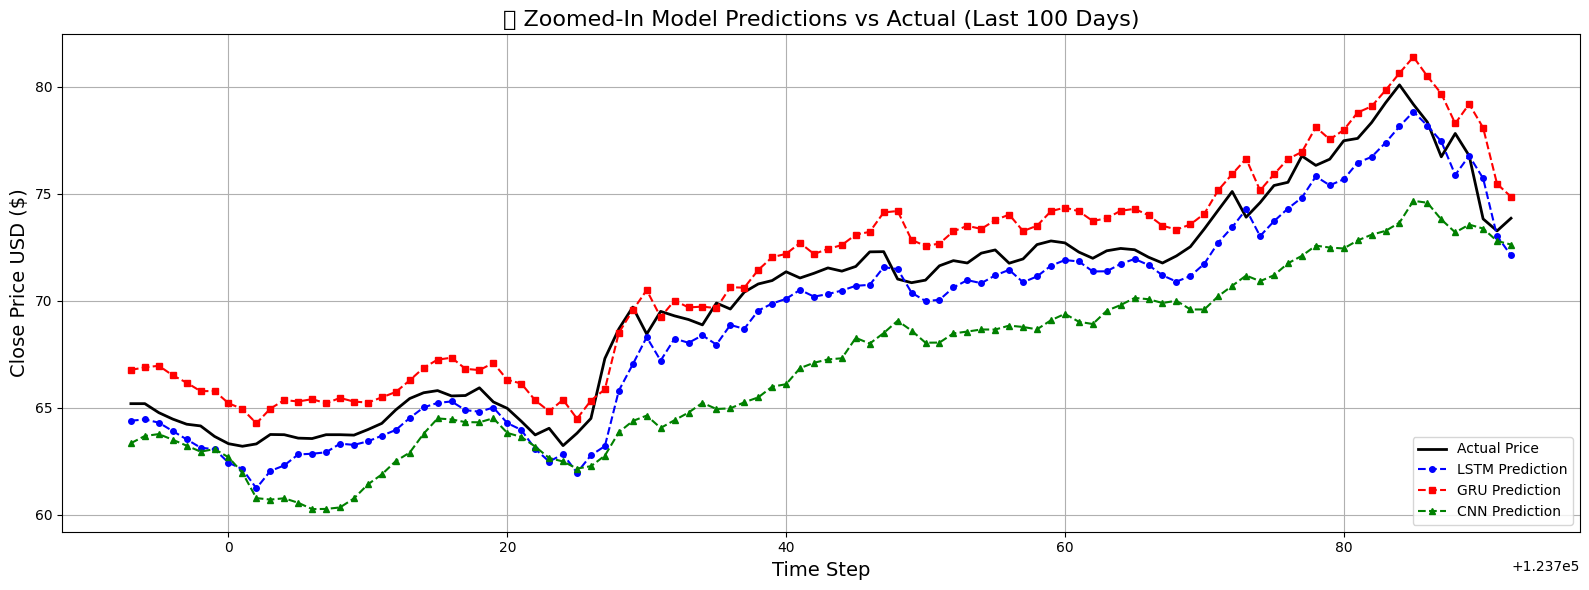

In [28]:
# Plot
plt.figure(figsize=(16, 6))
plt.title('📉 Zoomed-In Model Predictions vs Actual (Last {} Days)'.format(zoom_range), fontsize=16)
plt.plot(plot_df_zoomed['Actual'], label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df_zoomed['Predictions LSTM'], label='LSTM Prediction', linestyle='--', marker='o', markersize=4, color='blue')
plt.plot(plot_df_zoomed['Predictions GRU'], label='GRU Prediction', linestyle='--', marker='s', markersize=4, color='red')
plt.plot(plot_df_zoomed['Predictions CNN'], label='CNN Prediction', linestyle='--', marker='^', markersize=4, color='green')

plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

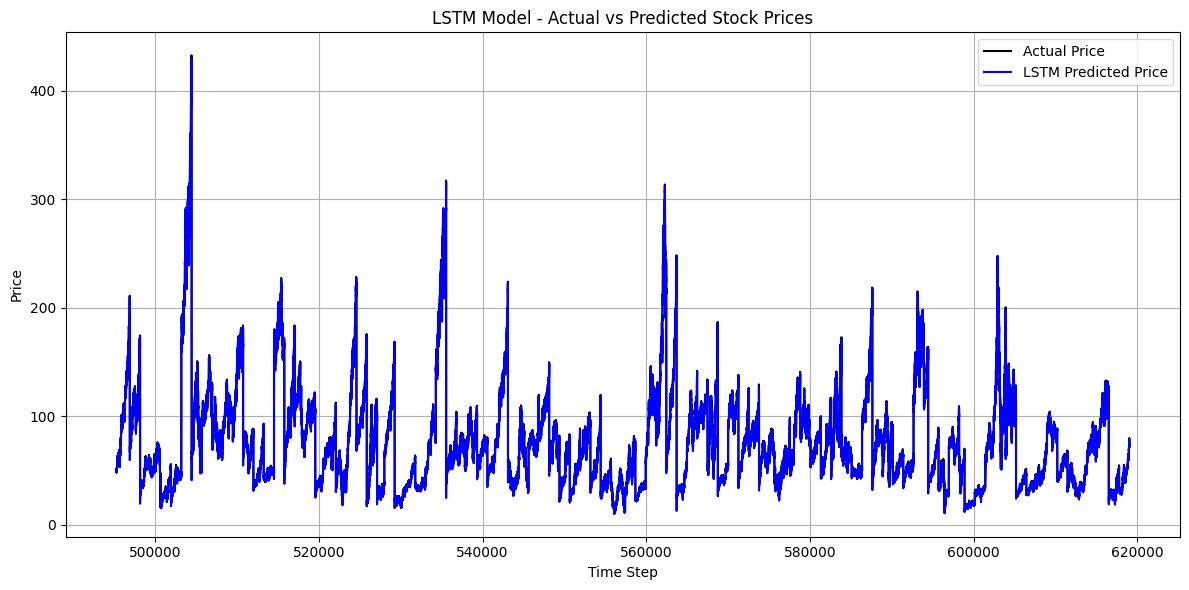

In [29]:
# LSTM model for Actual vs predicted stock price

plt.figure(figsize=(12, 6))

plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual Price', color='black')

plt.plot(df.index[-len(y_test):], y_pred_lstm,label='LSTM Predicted Price', color='blue')

plt.title('LSTM Model - Actual vs Predicted Stock Prices')

plt.xlabel('Time Step')

plt.ylabel('Price')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()

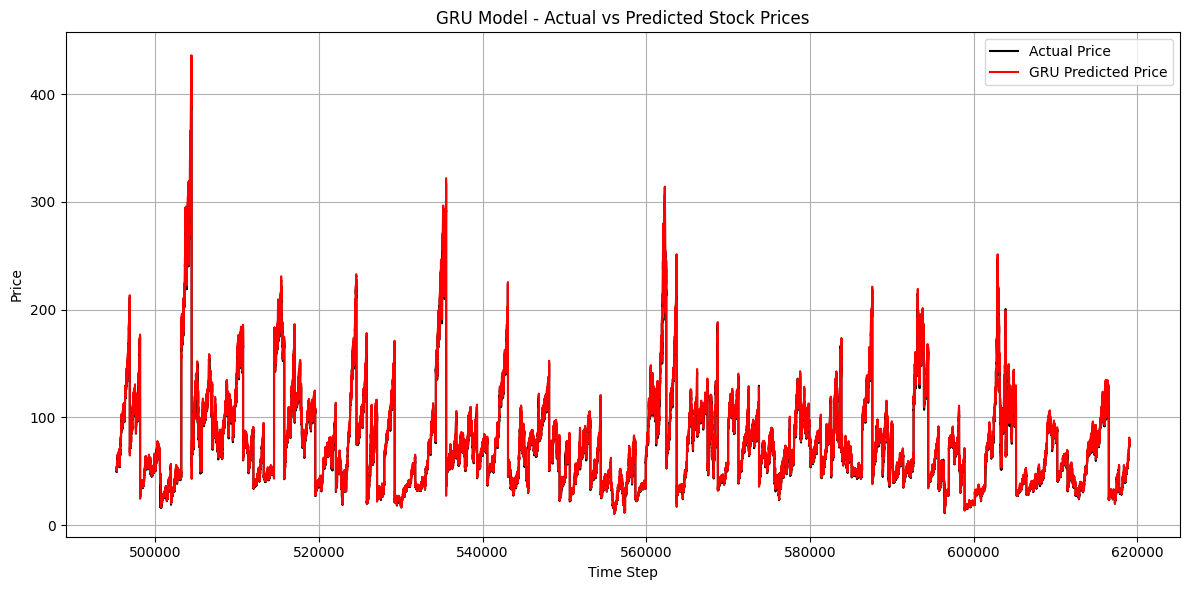

In [30]:
# GRU model for Actual vs predicted stock price

plt.figure(figsize=(12, 6))

plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual Price', color='black')

plt.plot(df.index[-len(y_test):], y_pred_gru, label='GRU Predicted Price', color='red')

plt.title('GRU Model - Actual vs Predicted Stock Prices')

plt.xlabel('Time Step')

plt.ylabel('Price')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()

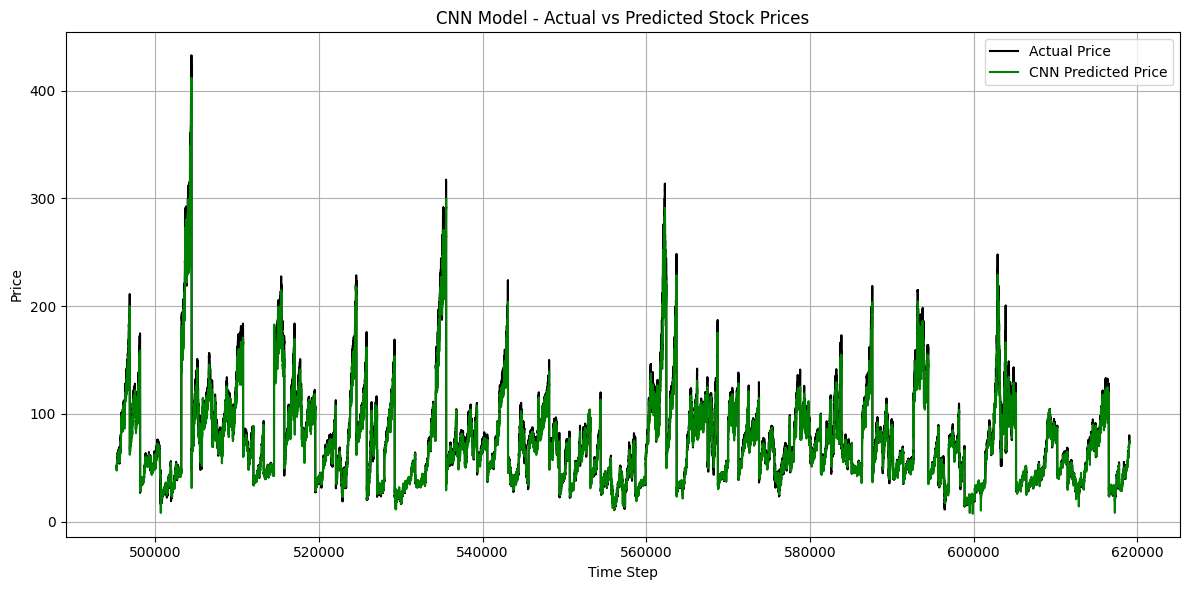

In [31]:
# CNN model for Actual vs predicted stock price

plt.figure(figsize=(12, 6))

plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual Price', color='black')

plt.plot(df.index[-len(y_test):], y_pred_cnn, label='CNN Predicted Price', color='green')

plt.title('CNN Model - Actual vs Predicted Stock Prices')

plt.xlabel('Time Step')

plt.ylabel('Price')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()